# Análisis del precio de la tortilla en México mediante regresión lineal

Este proyecto analiza la evolución del precio de la tortilla en México utilizando modelos de regresión lineal.
Los objetivos principales son:

- Explorar el comportamiento histórico del precio de la tortilla por kilogramo.
- Identificar la relación entre el precio y el tiempo (año, mes).
- Construir un modelo de regresión lineal y evaluar su capacidad explicativa.
- Estimar el precio promedio esperado para el siguiente año con base en la tendencia observada.

Instalamos todas las librerias que vamos a usar en este proyecto

In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import statsmodels.formula.api as smf

plt.style.use('default')
plt.rcParams['figure.figsize'] = (8, 5)
plt.rcParams['axes.grid'] = True

Se carga el archivo `tortilla_prices.csv` y se realiza una inspección básica de:

- Dimensiones del dataset.
- Tipos de datos por columna.
- Estadísticos descriptivos iniciales.

In [85]:
# Carga del dataset
data = pd.read_csv('tortilla_prices.csv')

# Copia de trabajo
df = data.copy()

# Información general del DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300486 entries, 0 to 300485
Data columns (total 7 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   State               300486 non-null  object 
 1   City                300486 non-null  object 
 2   Year                300486 non-null  int64  
 3   Month               300486 non-null  int64  
 4   Day                 300486 non-null  int64  
 5   Store type          300486 non-null  object 
 6   Price per kilogram  294096 non-null  float64
dtypes: float64(1), int64(3), object(3)
memory usage: 16.0+ MB


Mostramos los estadísticos descriptivos de las variables numéricas:

In [86]:
df.describe()

,Year,Month,Day,Price per kilogram
count,300486.000000,300486.000000,300486.000000,294096.000000
mean,2015.748890,6.362513,15.934922,12.615429
std,5.309467,3.418766,8.752586,4.888099
min,2007.000000,1.000000,1.000000,0.000000
25%,2011.000000,3.000000,8.000000,9.700000
50%,2016.000000,6.000000,16.000000,11.500000
75%,2020.000000,9.000000,24.000000,14.500000
max,2025.000000,12.000000,31.000000,31.710000


Se revisa la cantidad y proporción de valores nulos en el dataset para determinar si es necesario aplicar algún tratamiento adicional.

In [87]:
# Conteo de valores nulos por columna
null_counts = df.isnull().sum()
print('Conteo de valores nulos por columna:')
print(null_counts)

# Porcentaje total de valores nulos sobre el número de filas
null_percentage = (df.isnull().sum().sum() / len(df)) * 100
print(f'Participación porcentual de valores nulos en el dataset: {null_percentage:.2f}%')


Conteo de valores nulos por columna:
State                    0
City                     0
Year                     0
Month                    0
Day                      0
Store type               0
Price per kilogram    6390
dtype: int64
Participación porcentual de valores nulos en el dataset: 2.13%


Dado que la participación de valores nulos es muy baja, se eliminan los registros con nulos para trabajar con una base limpia llamada `df_c`.

In [91]:
df_c = df.dropna()
print(df_c.head())
print(f'Los valores nulos son: {df_c.isnull().sum().sum()}')

                 State            City  Year  Month  Day         Store type  \
0       Aguascalientes  Aguascalientes  2007      1   10  Mom and Pop Store   
2      Baja California         Tijuana  2007      1   10  Mom and Pop Store   
3  Baja California Sur          La Paz  2007      1   10  Mom and Pop Store   
4             Campeche        Campeche  2007      1   10  Mom and Pop Store   
5             Coahuila  Piedras Negras  2007      1   10  Mom and Pop Store   

   Price per kilogram  
0                 9.9  
2                10.0  
3                10.0  
4                10.0  
5                10.0  
Los valores nulos son: 0


##Evolución del precio promedio por año

A continuación se visualiza el precio promedio de la tortilla por kilogramo a lo largo de los años, con el fin de identificar tendencias generales.


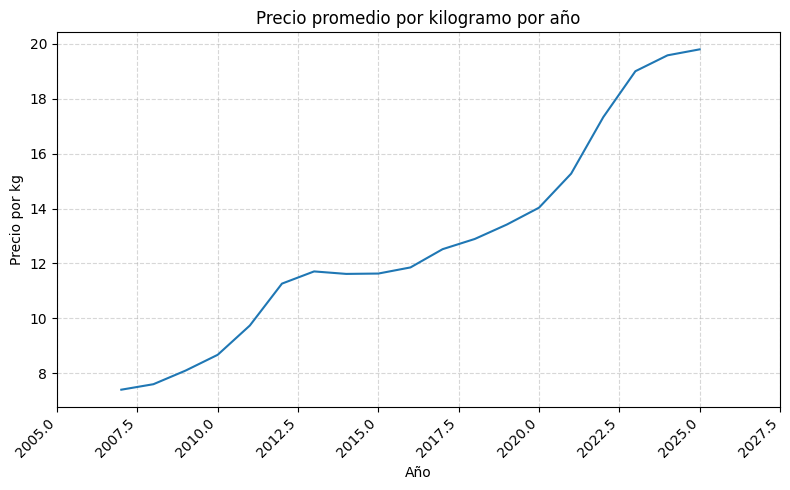

In [100]:
ax = df_c.groupby('Year')['Price per kilogram'].mean().plot(figsize=(8,5))

# Títulos
ax.set_title("Precio promedio por kilogramo por año")
ax.set_xlabel("Año")
ax.set_ylabel("Precio por kg")

# Rotar etiquetas del eje X
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Grid opcional
ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

Se genera un mapa de calor de correlaciones entre las variables numéricas:

- `Year`
- `Month`
- `Day`
- `Price per kilogram`

El objetivo es evaluar la fuerza y dirección de la relación entre estas variables y el precio.

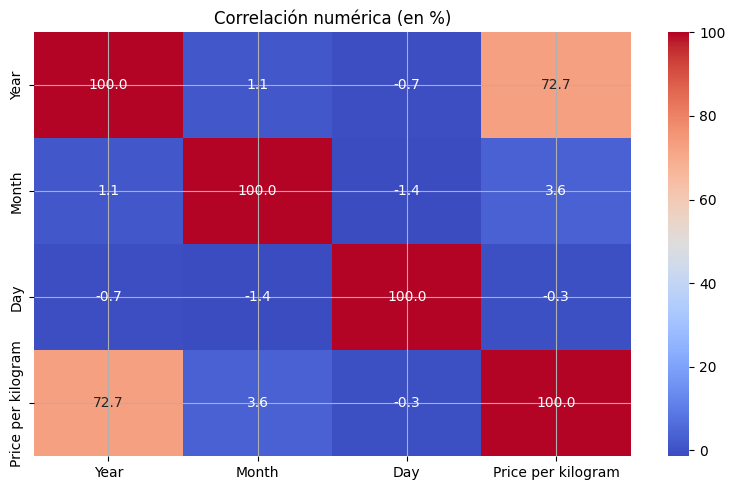

In [101]:
corr_numeric = df_c.select_dtypes(include=['number']).corr()

plt.figure(figsize=(8, 5))
sns.heatmap(corr_numeric * 100, annot=True, fmt='.1f', cmap='coolwarm')
plt.title('Correlación numérica (en %)')
plt.tight_layout()
plt.show()

La variable `Year` presenta la correlación más fuerte con el precio por kilogramo, lo que sugiere una tendencia temporal aprovechable mediante un modelo de regresión lineal.

Modelo de regresión lineal con sklearn

Como primer modelo se utiliza regresión lineal mediante `sklearn`, tomando como variables independientes:

- `Year`
- `Month`

y como variable dependiente:

- `Price per kilogram`.

In [102]:
# Definición de variables
X = df_c[['Year', 'Month']]
y = df_c['Price per kilogram']

# División en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [103]:
# Entrenamiento del modelo
model_skl = LinearRegression()
model_skl.fit(X_train, y_train)

# Predicciones sobre el conjunto de prueba
y_pred = model_skl.predict(X_test)

In [104]:
# Cálculo de métricas
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'R²: {r2:.3f}')
print(f'MSE: {mse:.2f}')
print(f'RMSE: {rmse:.2f}')

R²: 0.531
MSE: 11.20
RMSE: 3.35


Visualizamos predicciones y residuos

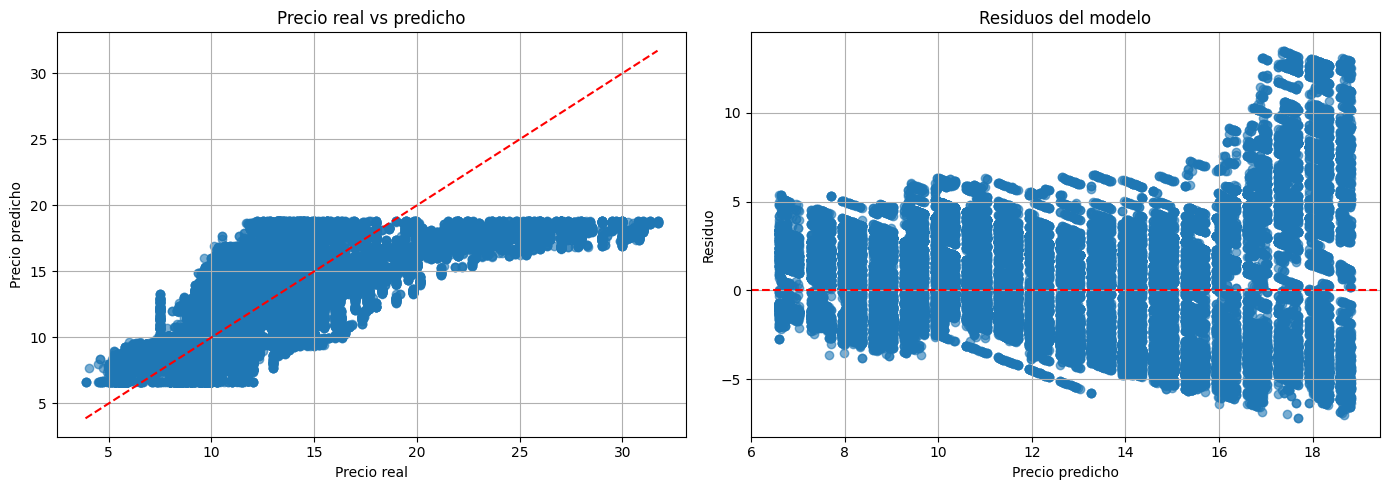

In [105]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Real vs predicho
axes[0].scatter(y_test, y_pred, alpha=0.6)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
axes[0].set_title('Precio real vs predicho')
axes[0].set_xlabel('Precio real')
axes[0].set_ylabel('Precio predicho')

# Residuos
residuos = y_test - y_pred
axes[1].scatter(y_pred, residuos, alpha=0.6)
axes[1].axhline(y=0, color='r', linestyle='--')
axes[1].set_title('Residuos del modelo')
axes[1].set_xlabel('Precio predicho')
axes[1].set_ylabel('Residuo')

plt.tight_layout()
plt.show()

- El valor de R² indica la proporción de variabilidad del precio que es explicada por el modelo. Un valor en torno a 0.53 implica que el modelo captura un poco más de la mitad de la variación del precio.
- El MSE (Mean Squared Error) mide el error cuadrático medio en unidades al cuadrado.
- El RMSE (Root Mean Squared Error) devuelve el error típico en las mismas unidades que la variable objetivo (pesos por kilogramo). Un RMSE cercano a 3 pesos por kilogramo implica un error moderado respecto al nivel promedio de precios observado.


**Modelo de regresión lineal con Statsmodels**

Ahora se utiliza `statsmodels` para ajustar un modelo de regresión lineal simple de la forma:

\[ price \sim Year \]

Esto permite obtener los coeficientes del modelo y su significancia estadística.

In [106]:
# Preparación del DataFrame para statsmodels
df_st = df_c.copy().rename(columns={
    'Price per kilogram': 'price',
    'Store type': 'store_type'
})

# División en entrenamiento y prueba
train, test = train_test_split(df_st, test_size=0.2, random_state=42)

In [107]:
# Modelo simple: price ~ Year
model_sm = smf.ols('price ~ Year', data=train).fit()

# Resumen del modelo
print(model_sm.summary())

# Predicciones sobre el conjunto de prueba
pred_sm = model_sm.predict(test)

mae_sm = mean_absolute_error(test['price'], pred_sm)
rmse_sm = np.sqrt(mean_squared_error(test['price'], pred_sm))

print(f'MAE (Statsmodels): {mae_sm:.2f}')
print(f'RMSE (Statsmodels): {rmse_sm:.2f}')
print(f'R² (train, Statsmodels): {model_sm.rsquared:.3f}')



                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.528
Model:                            OLS   Adj. R-squared:                  0.528
Method:                 Least Squares   F-statistic:                 2.630e+05
Date:                Fri, 21 Nov 2025   Prob (F-statistic):               0.00
Time:                        23:34:45   Log-Likelihood:            -6.1895e+05
No. Observations:              235276   AIC:                         1.238e+06
Df Residuals:                  235274   BIC:                         1.238e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1330.4186      2.619   -508.005      0.0

Los resultados del modelo con `statsmodels` son muy similares a los obtenidos con `sklearn`, lo que confirma que la estructura temporal (el año) es uno de los principales factores que explican el comportamiento del precio de la tortilla.

**Predicción del precio promedio del siguiente año**

Se ajusta nuevamente el modelo `price ~ Year` utilizando todo el dataset limpio, con el objetivo de estimar el precio promedio esperado para el siguiente año completo.

In [108]:
# DataFrame para predicción
df_pred = df_c.copy().rename(columns={
    'Price per kilogram': 'price',
    'Store type': 'store_type'
})

# Modelo lineal para todo el dataset
model_pred = smf.ols('price ~ Year', data=df_pred).fit()

# Año máximo disponible en los datos
ultimo_anio = df_pred['Year'].max()
precio_promedio_ultimo_anio = df_pred[df_pred['Year'] == ultimo_anio]['price'].mean()
siguiente_anio = ultimo_anio + 1

# Predicción para el siguiente año
prediccion_siguiente = model_pred.predict({'Year': siguiente_anio})[0]

print(f'Último año en datos: {ultimo_anio}, con un precio promedio observado de ${precio_promedio_ultimo_anio:.2f} por kg.')
print(f'Predicción del precio promedio para {siguiente_anio} según la tendencia lineal: ${prediccion_siguiente:.2f} por kg.')


Último año en datos: 2025, con un precio promedio observado de $19.80 por kg.
Predicción del precio promedio para 2026 según la tendencia lineal: $19.48 por kg.


Es importante destacar que la predicción se basa en la tendencia lineal ajustada sobre todos los años observados, por lo que no necesariamente coincidirá con el promedio real del último año, sino con el valor teórico que corresponde a la recta estimada.

## Comparación entre precio real y precio predicho por año

Para evaluar de forma más detallada el ajuste del modelo, se calcula:

- El precio promedio real por año.
- El precio promedio predicho por el modelo para cada año.
- La diferencia absoluta y porcentual entre ambos.


In [109]:
# Ajuste del modelo sobre todo el dataset limpio
model_all = smf.ols('price ~ Year', data=df_pred).fit()

# Predicción por fila y agregación por año
df_pred['y_hat'] = model_all.predict(df_pred[['Year']])

resumen = (
    df_pred.groupby('Year').agg(
        precio_real=('price', 'mean'),
        precio_modelo=('y_hat', 'mean')
    )
    .assign(
        diferencia=lambda x: x['precio_real'] - x['precio_modelo'],
        diferencia_pct=lambda x: (x['diferencia'] / x['precio_real']) * 100
    )
    .reset_index()
)

resumen.tail()

,Year,precio_real,precio_modelo,diferencia,diferencia_pct
14,2021,15.273879,16.144186,-0.870307,-5.698012
15,2022,17.333422,16.810762,0.522659,3.015326
16,2023,19.007899,17.477338,1.530561,8.052234
17,2024,19.586962,18.143914,1.443048,7.367389
18,2025,19.804538,18.810491,0.994048,5.019293


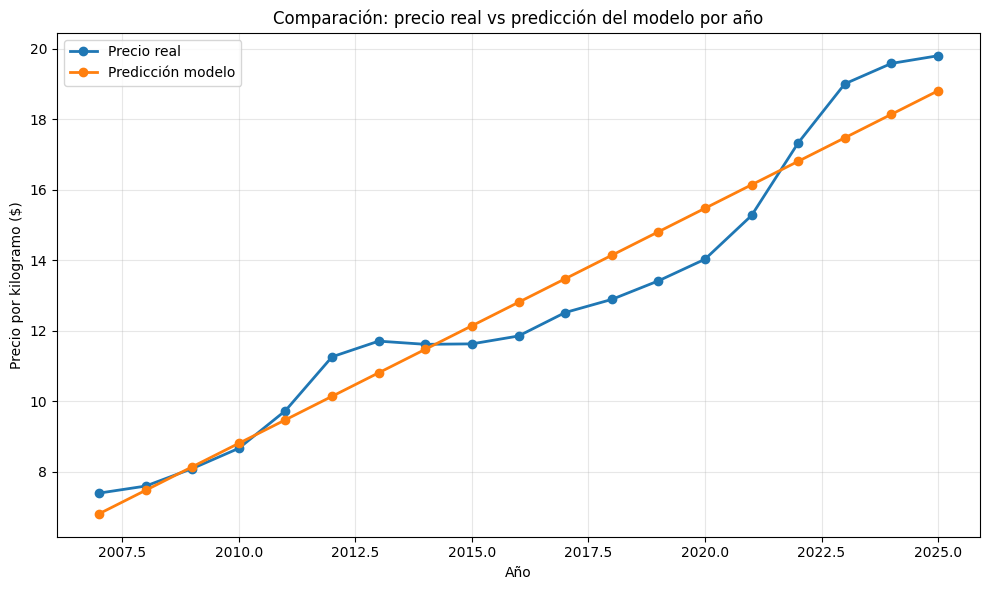

In [110]:
# Gráfico comparativo real vs modelo

plt.figure(figsize=(10, 6))

plt.plot(resumen['Year'], resumen['precio_real'], marker='o', label='Precio real', linewidth=2)
plt.plot(resumen['Year'], resumen['precio_modelo'], marker='o', label='Predicción modelo', linewidth=2)

plt.title('Comparación: precio real vs predicción del modelo por año')
plt.xlabel('Año')
plt.ylabel('Precio por kilogramo ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


La comparación muestra que, aunque el modelo no captura todas las fluctuaciones anuales, sigue adecuadamente la tendencia general del precio de la tortilla. Los años en los que el precio real se encuentra por encima de la línea del modelo pueden interpretarse como años relativamente más caros respecto a la tendencia histórica, y viceversa. Si tomasemos en cuenta los parametros de prediccion obtendiamos el sigueinte resultado:

In [111]:
print(model_pred.params)

Intercept   -1331.005969
Year            0.666576
dtype: float64


Pendiente (β1 = 0.666576):
Cada año el precio sube aprox. $0.66 pesos por kilo

Por lo tanto si tuvieramos una alineacion lineal completa deberiamos de tener una prediccion de la sigueinte manera:

pred_2026 = -1331.005969 + 0.666576*2026
          = 20.30

Por lo tanto el modelo deberia predecir que 2026 será ~ $20.30/kg


## **Conclusiones**

A partir del análisis realizado se pueden extraer las siguientes conclusiones principales:

1. El precio de la tortilla en México presenta una tendencia creciente a lo largo del tiempo, lo cual se refleja en el coeficiente positivo asociado a la variable `Year` en los modelos de regresión lineal.
2. El modelo de regresión lineal simple, utilizando únicamente el año (y en una segunda variante el año y el mes), logra explicar alrededor de la mitad de la variabilidad observada en el precio. Esto indica que existen otros factores relevantes (diferencias regionales, tipo de tienda, condiciones locales de mercado, entre otros) que no han sido incluidos en este análisis.
3. La predicción del precio promedio para el siguiente año, basada en la tendencia lineal, es coherente con el comportamiento histórico, aunque no coincide necesariamente con el último promedio observado, ya que la regresión ajusta una recta global a todos los datos.

